# Project: Monte Carlo Markov Chain Simulation

## Business goals:  

1. understand customer behavior  
2. explain customer behavior to non-data staff  
3. optimize staffing so that the queues do not get unnecessary long  

## Supermarket Area

We are using the following model supermarket with six areas: entrance, fruit, spices, dairy, drinks and checkout.

The customers can move between these areas freely. Sooner or later, they will enter the checkout area. Once they do, they are considered to have left the shop.

![Drag Racing](./supermarket.png)

### Load data

In [12]:
from os import listdir
from os.path import isfile, join

def load_data(day):
    path = './data/'
    r = pd.read_csv(os.path.join(path, day + '.csv'), sep=';', parse_dates=['timestamp'], index_col=['timestamp'])
    return r

df = load_data('monday')
for file in ['tuesday', 'wednesday', 'thursday', 'friday']:
    df_next = load_data(file)
    df_next['customer_no'] = df_next['customer_no'] + df['customer_no'].max()
    df = df.append(df_next)

# df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data analysis

### When customers enter the supermarket?

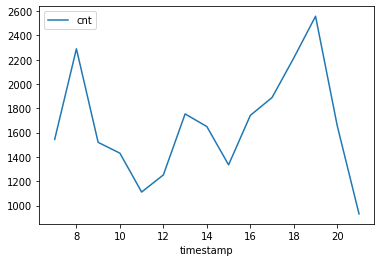

In [45]:
def show_enter_time_distribution(df):
    tmp = df.reset_index()
    tmp['cnt'] = 1
    tmp.groupby([tmp['timestamp'].dt.hour])[['cnt']].count().plot.line()
    
show_enter_time_distribution(df)

### How long users spend in the supermarket?

### Probabilities plot

what are the chances to be in a specific section?

### Revenue Estimate

## Marov chain

### Transitions matrix

### Monte carlo simulations

#### Simpulation 1

#### Simpulation 2

#### Simpulation 3